Sample data generated and saved to your_time_series_data.csv
Epoch 1/20


c:\Users\Ariful\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 - 2s - 15ms/step - loss: 0.0444
Epoch 2/20
149/149 - 0s - 3ms/step - loss: 0.0305
Epoch 3/20
149/149 - 0s - 2ms/step - loss: 0.0284
Epoch 4/20
149/149 - 0s - 2ms/step - loss: 0.0280
Epoch 5/20
149/149 - 0s - 2ms/step - loss: 0.0274
Epoch 6/20
149/149 - 0s - 2ms/step - loss: 0.0289
Epoch 7/20
149/149 - 0s - 2ms/step - loss: 0.0263
Epoch 8/20
149/149 - 0s - 2ms/step - loss: 0.0266
Epoch 9/20
149/149 - 0s - 2ms/step - loss: 0.0272
Epoch 10/20
149/149 - 0s - 2ms/step - loss: 0.0270
Epoch 11/20
149/149 - 0s - 2ms/step - loss: 0.0244
Epoch 12/20
149/149 - 0s - 2ms/step - loss: 0.0257
Epoch 13/20
149/149 - 0s - 2ms/step - loss: 0.0260
Epoch 14/20
149/149 - 0s - 2ms/step - loss: 0.0261
Epoch 15/20
149/149 - 0s - 2ms/step - loss: 0.0247
Epoch 16/20
149/149 - 0s - 2ms/step - loss: 0.0248
Epoch 17/20
149/149 - 0s - 2ms/step - loss: 0.0255
Epoch 18/20
149/149 - 0s - 2ms/step - loss: 0.0255
Epoch 19/20
149/149 - 0s - 2ms/step - loss: 0.0255
Epoch 20/20
149/149 - 0s - 2ms/step - loss: 0.0261

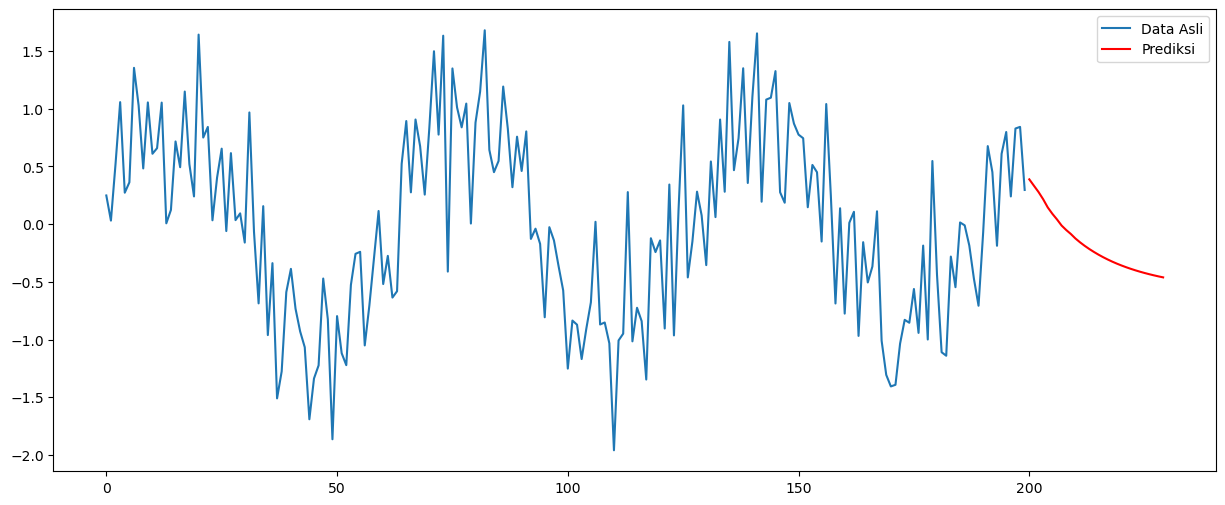

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Memahami dan Preprocessing Data
import os

csv_path = 'your_time_series_data.csv'
if not os.path.exists(csv_path):
    # Generate synthetic time series data
    np.random.seed(42)
    time = np.arange(0, 200)
    values = np.sin(0.1 * time) + np.random.normal(scale=0.5, size=len(time))
    df = pd.DataFrame({'your_column': values})
    df.to_csv(csv_path, index=False)
    print(f"Sample data generated and saved to {csv_path}")

data = pd.read_csv(csv_path)
data = data['your_column'].values.reshape(-1, 1)

# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Membagi Data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape input menjadi [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# 2. Membuat Model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Melatih Model
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

# 4. Mengevaluasi Model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse Transform Prediksi
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Hitung RMSE
train_score = np.sqrt(np.mean(np.power((y_train[0] - train_predict[:, 0]), 2)))
test_score = np.sqrt(np.mean(np.power((y_test[0] - test_predict[:, 0]), 2)))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

# 5. Membuat Prediksi ke Depan
last_data = scaled_data[-look_back:]
prediction = []
for _ in range(30):  # Prediksi untuk 30 waktu ke depan
    pred_input = last_data[-look_back:].reshape(1, look_back, 1)
    pred = model.predict(pred_input)
    prediction.append(pred[0, 0])
    last_data = np.append(last_data, pred)[-look_back:]

prediction = scaler.inverse_transform(np.array(prediction).reshape(-1, 1))

# Plot hasil prediksi
plt.figure(figsize=(15, 6))
plt.plot(data, label='Data Asli')
plt.plot(range(len(data), len(data) + len(prediction)), prediction, label='Prediksi', color='red')
plt.legend()
plt.show()
